In [1]:
%reload_ext autoreload

%reset

import sys
sys.path.append("../")

import numpy as np
from scipy.stats import poisson
from astropy import units

import pickle as pk

import healpy as hp

import matplotlib.pyplot as pl
import matplotlib

#For making corner plots
from getdist import plots, MCSamples

import pdb

import EPDFABC as epdfabc
import subhalos as subs
import FermiBackgrounds
import DMsignal
import abc_funcs as af



#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True

matplotlib.use('PS')

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
load_data = True
load_pf = True
save_data = False
save_posterior = True
include_bg = True
vary_DMmass = False
N_E_bins = 1

channel = 'Tau'
if (channel == 'Tau'):
    suffix = 'tau_default_NE10_MMin1_10yr_masked_fixedfov'
if (channel == 'b'):
    suffix = 'b_default_NE10_MMin1_10yr_masked_fixedfov'

In [3]:
my_DM = DMsignal.DMsignal('../data/dm_spectra/', channel)
default_param_dict = my_DM.get_default_model()
default_params = np.array([default_param_dict['A_DM'],\
                           default_param_dict['A_BG'],\
                           default_param_dict['mass_DM_MeV']])
print("default params = ", default_param_dict)

#parameter ranges
if (channel == 'Tau'):
    param_min_all = np.array([0.2, 0.98, 0.1])*default_params
    param_max_all = np.array([2.5, 1.02, 1.9])*default_params
if (channel == 'b'):
    param_min_all = np.array([0.1, 0.99, 0.1])*default_params
    param_max_all = np.array([4, 1.01, 1.9])*default_params


param_names_all = np.array(['ADM', 'bgnorm', 'MDM'])
param_labels_all = np.array(['\\A_{DM}', '\\A_{\rm bg}', '\\M_{\chi}'])

if (not include_bg):
    free_indices = np.array([0])
else:
    if (not vary_DMmass):
        free_indices = np.array([0,1])
    else:
        free_indices = np.array([0,1,2])
true_params = default_params[free_indices]   
param_names = param_names_all[free_indices]
param_labels = param_labels_all[free_indices]
param_min = param_min_all[free_indices]
param_max = param_max_all[free_indices]
param_range = [param_min, param_max]

physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'fast')
print(physics_settings)
print(obs_settings)

#Properties of summary statistic
count_range = [0,700] #[0,250]
energy_range = [1000, 100000] #this is in MeV, important since used for backgrounds

# Set up background generator
fermi_data_path = '../data/FermiData/'
background_generator = FermiBackgrounds.FermiBackgrounds(fermi_data_path)

# For exact likelihood, we'll use unit width bins
cmax_summary = np.max(count_range)
nbins_summary = cmax_summary
logbins = False

#For exact likelihood, don't normalize params
normalize_mean = [0., 0., 0.]
normalize_std = [1., 1., 1.]

#Bin settings
summary_properties = {'type': 'histogram' ,'Nbins':nbins_summary, \
                      'Cmax_hist': cmax_summary, 'Cmin_hist': 0, 'logbins':logbins}

print("free params = ", param_names)

default params =  {'A_DM': 200.0, 'A_BG': 1.0, 'mass_DM_MeV': 200000.0}
{'R_G': 220, 'd_sun': 8.5, 'M_max': 10000000000.0, 'M_min': 1.0, 'PhiPP': 1.0, 'n': 0, 'beta': 1.9, 'lum_model': 'default', 'l_min': 0.001}
{'area': 2000.0, 'obs_time': 10.0, 'fov_factor': 0.2, 'Omega_pixel': 0.00025566346464760684, 'psi': 1.7453292519943295}
free params =  ['ADM' 'bgnorm']


In [4]:
# Settings for subhalo analysis
default_phipp = physics_settings['PhiPP']
N_pix_fullsky = int(4.*np.pi/obs_settings['Omega_pixel'])
N_side = int(np.sqrt(N_pix_fullsky/12.0))

exposure = (( obs_settings['fov_factor']*obs_settings['obs_time']*units.yr * obs_settings['area']*units.cm**2).to('s*cm**2')).value
Sangle = obs_settings['Omega_pixel']

print("N_side = ", N_side)

N_side =  64


In [5]:
#sky masking
do_mask = True
if (not do_mask):
    N_pix = N_pix_fullsky
    mask = np.ones(N_pix)
    gal_lat_cut = 0.
    gal_cent_cut = 0.
else:
    gal_lat_cut = 30.
    gal_cent_cut = 60.
    mask = background_generator.get_mask(N_side, gal_lat_cut, gal_cent_cut)
    
    mask_indices = np.where(mask > 0)[0]
    N_pix = len(mask_indices)


In [6]:
# Compute the PDF of photon counts using the Fourier transform trick.  Note that this can be slow.
if (not load_pf):
    maxc = 100.
    counts = np.arange(0,maxc)
    pc, f_pf_precomputed, pf_pf_precomputed = subs.get_pc(counts, physics_settings, fft_settings, \
                                                             obs_settings, return_fpf = True)
    save_pf = True
    if save_pf:
        pf_data = {'maxc':maxc, 'pc':pc, 'counts':counts, 'f_pf_precomputed':f_pf_precomputed, \
                   'pf_pf_precomputed':pf_pf_precomputed}
        pk.dump(pf_data, open('../data/pf_calculation/pf_saved_hires_mmin1_wtf.pk','wb'))
else:
    pf_data = pk.load(open('../data/pf_calculation/pf_saved_hires_mmin1.pk','rb'))
    maxc = pf_data['maxc']
    pc = pf_data['pc']
    counts = pf_data['counts']
    
    f_pf_precomputed = pf_data['f_pf_precomputed']
    pf_pf_precomputed = pf_data['pf_pf_precomputed']


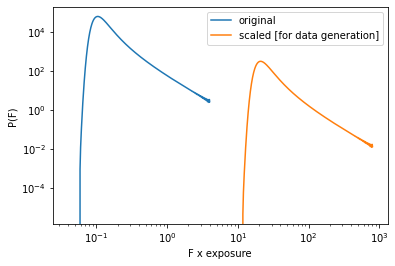

In [7]:
#Plot P(F) and P(C)

fig, ax = pl.subplots(1,1)
scaling = obs_settings['obs_time']*obs_settings['area']*obs_settings['fov_factor']
ax.plot(f_pf_precomputed*scaling, pf_pf_precomputed, label = 'original')
ax.plot(f_pf_precomputed*scaling*default_params[0], pf_pf_precomputed/default_params[0], label = 'scaled [for data generation]')
ax.set_xlabel('F x exposure')
ax.set_ylabel('P(F)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()


In [8]:
#Backgrounds

# Energy spectrum setup
#We use FermiBackgrounds to get the background spectrum and mean flux
fermi_iso = background_generator.get_isotropic_background_spectrum_func()
mean_iso_bg_flux = background_generator.get_masked_isotropic_flux('../data/FermiData/galactic_bg_healpix_Nside64.pk',\
                                                gal_lat_cut, gal_cent_cut, energy_range[0], energy_range[1])

In [9]:
if (include_bg):
    PDF_and_spectra = [[af.background_pdf_wrapper, af.background_spec_wrapper], \
                       [af.subhalo_pdf_wrapper, af.subhalo_spec_wrapper]]
    is_isotropic_list = [True, True]
    is_poisson_list = [False, False]
else:
    PDF_and_spectra = [[af.subhalo_pdf_wrapper, af.subhalo_spec_wrapper]]
    is_isotropic_list = [True]
    is_poisson_list = [False]
    
# initialize the EPDFABC object
my_abc = epdfabc.EPDFABC(param_range)

#Arguments passed to PDF and spectrum functions
args = {'normalize_mean':normalize_mean, 'normalize_std':normalize_std,\
        'vary_DMmass':vary_DMmass,\
        'default_params':default_params,\
        'energy_range':energy_range,\
        'my_DM':my_DM,\
        'f_pf_precomputed':f_pf_precomputed, 'pf_pf_precomputed':pf_pf_precomputed, \
        'exposure':exposure, \
        'Sangle':Sangle, \
        'mean_iso_bg_flux':mean_iso_bg_flux, \
        'fermi_iso':fermi_iso, \
        'default_phipp':default_phipp
}

#Setup for binned analysis
my_abc.setup_binned(PDF_and_spectra, is_isotropic_list, is_poisson_list, count_range, \
                    energy_range, N_E_bins, obs_settings['Omega_pixel'], verbose = False, args = args)    

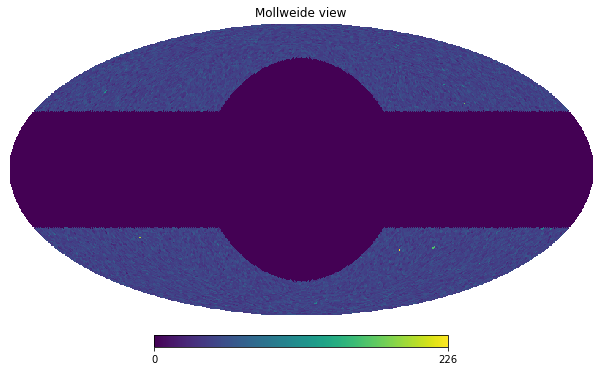

In [10]:
#Generate mock data
skymap_filename = 'skymap_' + suffix + '.pk'

if (not load_data): 
    #draw mock data
    obs_data = my_abc.generate_mock_data_binned(true_params, exposure = exposure, N_pix = N_pix)
    map_to_plot = np.zeros(len(mask))
    mask_indices = np.where(mask > 0)[0]
    map_to_plot[mask_indices] = obs_data[0,:,0]
    hp.mollview(map_to_plot, title = 'Mock data')
if (load_data):
    skydict = pk.load(open('../data/skymaps/' + skymap_filename, 'rb'))
    #print(skydict.keys())
    obs_data = np.expand_dims(np.sum(skydict['obs_data'],axis=2),axis=2)
    #print(obs_data.shape)
    map_to_plot = np.zeros(len(skydict['mask']))
    mask_indices = np.where(skydict['mask'] > 0)[0]
    map_to_plot[mask_indices] = obs_data[0,:,0]
    hp.mollview(map_to_plot)
    
#Output mock data
if (save_data):
    to_save = {'physics_settings':physics_settings, \
               'obs_settings':obs_settings, \
               'fft_settings':fft_settings, \
               'obs_data':obs_data,\
               'N_E_bins':N_E_bins,\
               'maxc':maxc,\
               'true_params':true_params,\
               'include_bg':include_bg,\
               'mask':mask}
    save_dir = './data/skymaps/'
    pk.dump(to_save, open(save_dir + skymap_filename, 'wb'))
    

In [11]:
# Run likelihood analysis

def get_lnlikelihood(obs_data_in, params):
    #Get subhalo PDF
    counts = np.arange(0,max(obs_data_in))
    signal_pc = af.subhalo_pdf_wrapper(params, counts, args)
    
    if (not include_bg):
        lnlike = np.sum(np.log(signal_pc[obs_data_in]))
    else:
        background_pc =  af.background_pdf_wrapper(params, counts, args)
        total_pc = np.convolve(background_pc, signal_pc)
        total_pc = total_pc/np.sum(total_pc)
        lnlike = np.sum(np.log(total_pc[obs_data_in]))
        
    return lnlike

ADM_arr = np.linspace(param_min_all[0], param_max_all[0], num = 21)

if (include_bg):
    background_norm_arr = np.linspace(param_min_all[1], param_max_all[1], num = 22)
    #background_norm_arr = np.array([1.])
    lnlike_arr = np.zeros((len(ADM_arr), len(background_norm_arr)))
else:
    lnlike_arr = np.zeros(len(ADM_arr))

#If no backgrounds, do one parameter analysis
if (not include_bg):
    for pi in range(0,len(ADM_arr)):
        params = np.zeros(1)
        params[0] = ADM_arr[pi]
        lnlike = get_lnlikelihood(obs_data[:,0], params)
        lnlike_arr[pi] = lnlike
        
#with backgrounds, do two parameter analysis
if (include_bg):
    for pi in range(0,len(ADM_arr)):
        print("pi = ", pi)
        for bi in range(0,len(background_norm_arr)):
            params = np.zeros(2)
            params[0] = ADM_arr[pi]
            params[1] = background_norm_arr[bi]
            lnlike = get_lnlikelihood(obs_data[0,:,0].astype('int'), params)
            lnlike_arr[pi,bi] = lnlike
    
print("Done")

pi =  0
pi =  1
pi =  2
pi =  3
pi =  4
pi =  5
pi =  6
pi =  7
pi =  8
pi =  9
pi =  10
pi =  11
pi =  12
pi =  13
pi =  14
pi =  15
pi =  16
pi =  17
pi =  18
pi =  19
pi =  20
Done


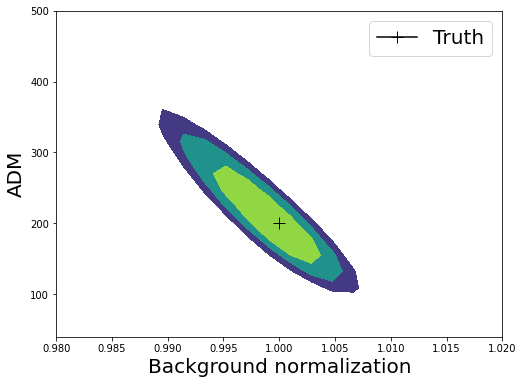

In [12]:
#Plot likelihood as function of PhiPP

if (not include_bg):
    fig, ax = pl.subplots(1,1)
    ax.plot(ADM_arr, np.exp(lnlike_arr - np.max(lnlike_arr)))
    ax.plot([1.0, 1.0], [0., 1.], ls = 'dashed', color = 'black', label = 'Input PhiPP')
    #ax.set_xscale('log')
    ax.set_xlabel('ADM')
    ax.set_ylabel('Likelihood')
    ax.legend()
else:
    fig, ax = pl.subplots(1,1, figsize = (8,6))
    ax.contourf(background_norm_arr, ADM_arr, lnlike_arr, levels = np.max(lnlike_arr) - [6,4,2,0])
    #ax.contourf(background_norm_arr, phipp_arr, lnlike_arr)
    ax.plot([default_params[1]], [default_params[0]], marker = '+', color = 'black', markersize = 12, label = 'Truth')
    #ax.set_yscale('log')
    ax.set_xlabel('Background normalization', fontsize = 20)
    ax.set_ylabel('ADM', fontsize = 20)    
    ax.legend(fontsize = 20)

#save posterior
if (save_posterior):
    save_like_dir = '../data/exact_likelihoods/'
    save_like_filename = 'likelihood_' + skymap_filename[:-3] + '.pk'
    if (include_bg):
        save_like_data = {'ADM_arr':ADM_arr, 'background_norm_arr':background_norm_arr, \
                          'lnlike_arr':lnlike_arr, 'default_params':default_params}
    if (not include_bg):
        save_like_data = {'default_params':default_params, 'ADM_arr':ADM_arr, 'lnlike_arr':lnlike_arr}
    pk.dump(save_like_data, open(save_like_dir + save_like_filename, 'wb'))


Text(0.5, 0, 'A_BG')

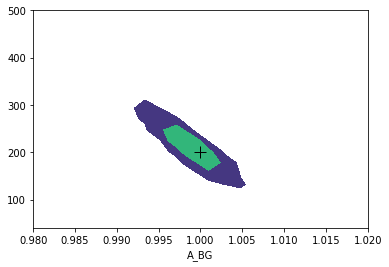

In [13]:
def get_contour_levels(prob_mat, desired_prob_levels = [0.68, 0.95]):
    #normalize the probability matrix
    prob_mat_normalized = prob_mat/np.sum(prob_mat)
    
    #sort highest to lowest probability
    prob_sort_indices = np.argsort(prob_mat_normalized.flatten())[::-1]
    prob_sorted = prob_mat_normalized.flatten()[prob_sort_indices]
    
    #take cumulative sum of this sorted array - whenever this crosses desired threshold,
    #that will be a contour level
    cumulative_prob = np.cumsum(prob_sorted)
    
    output_levels = np.zeros(len(desired_prob_levels))
    for ci in range(0,len(desired_prob_levels)):
        index = np.min(np.where(cumulative_prob > desired_prob_levels[ci])[0])
        output_levels[ci] = prob_sorted[index]
    return prob_mat_normalized, np.flip(output_levels)

#post_load = pk.load(open('./data/exact_likelihoods/likelihood_skymap_v01b.pk','rb'))
#lnposterior = post_load['lnlike_arr']
prob_mat = np.exp(lnlike_arr - np.max(lnlike_arr))
prob_mat_normalized, c_levels = get_contour_levels(prob_mat, desired_prob_levels = [0.0, 0.68, 0.95])

fig,ax = pl.subplots(1,1)
ax.contourf(background_norm_arr, ADM_arr, prob_mat_normalized, \
            levels = c_levels)
ax.plot([default_params[1]], [default_params[0]], marker = '+', color = 'black', markersize = 12, label = 'Truth')
ax.set_xlabel('A_BG')

[2.e+02 1.e+00 2.e+05]
1.0
{'R_G': 220, 'd_sun': 8.5, 'M_max': 10000000000.0, 'M_min': 1.0, 'PhiPP': 1.0, 'n': 0, 'beta': 1.9} {'minF': 1e-16, 'maxF': 100000.0, 'numF': 4096, 'minlnk': -6.907755278982137, 'maxlnk': 15.424948470398375, 'numk': 8192, 'minf_out': 1e-05, 'maxf_out': 0.001, 'numf_out': 512, 'minf_pc': 1e-05, 'maxf_pc': 0.0008} {'area': 2000.0, 'obs_time': 10.0, 'fov_factor': 0.2, 'Omega_pixel': 0.00025566346464760684, 'psi': 1.7453292519943295}


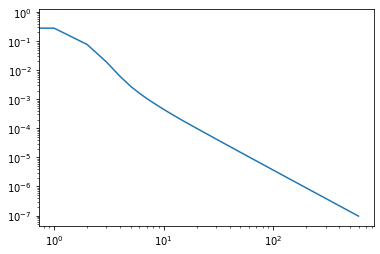

In [27]:
print(default_params)
print(default_phipp)
print(physics_settings, fft_settings, obs_settings)

cc = np.arange(0,600)
pc_dm = af.subhalo_pdf_wrapper(default_params, cc, args)
fig, ax = pl.subplots(1,1)
ax.plot(cc, pc_dm)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim((5.0e-6, 5.0))

In [ ]:
# Get default PhiPP

A_DM = default_params[0]
mass_DM_MeV = default_params[2]

#DMe, DMdnde = DMsignal.get_signal_spectrum(DMchannel, DMmass)
#DMspectrum = scipy.interpolate.interp1d(DMe, DMdnde)
E = np.exp(np.linspace(np.log(energy_range[0]), np.log(energy_range[1]), 1000))
dE = E[1:] - E[:-1]
dNdE = my_DM.get_dNdE(E, channel, mass_DM_MeV)

PhiInt = np.sum(0.5*dE*(dNdE[1:]+dNdE[:-1]))
sigv = 3e-26 #cm^3 s^-1 # fiducial cross section for thermal relic DM
PhiPP = sigv*A_DM*PhiInt/(8*np.pi*(mass_DM_MeV/1e3)**2)
PhiPP_0 = (1e-28)/(8*np.pi) #cm^3 s^-1 GeV^-2
print(PhiPP_0)

In [ ]:
'''
# Set up mock data generation

#set up wrappers for pdf and spectra
def subhalo_pdf_wrapper(params, counts):
    A_DM = params[0]
    mass_DM_MeV = default_params[2]
    
    #DMe, DMdnde = DMsignal.get_signal_spectrum(DMchannel, DMmass)
    #DMspectrum = scipy.interpolate.interp1d(DMe, DMdnde)
    E = np.exp(np.linspace(np.log(energy_range[0]), np.log(energy_range[1]), 1000))
    dE = E[1:] - E[:-1]
    dNdE = my_DM.get_dNdE(E, channel, mass_DM_MeV)

    PhiInt = np.sum(0.5*dE*(dNdE[1:]+dNdE[:-1]))
    sigv = 3e-26 #cm^3 s^-1 # fiducial cross section for thermal relic DM
    PhiPP = sigv*A_DM*PhiInt/(8*np.pi*(mass_DM_MeV/1e3)**2)
    PhiPP_0 = (1e-28)/(8*np.pi) #cm^3 s^-1 GeV^-2
    
    physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'fast')
    physics_settings['PhiPP'] = PhiPP/PhiPP_0
    #print("PhiPP/PhiPP_0 = ", PhiPP/PhiPP_0)
    pc = subs.get_pc_fast(counts, f_pf_precomputed, pf_pf_precomputed, \
                          physics_settings, fft_settings, obs_settings, \
                          default_phipp = default_phipp, do_extend = True)
    pc = pc/np.sum(pc)
    return pc

def subhalo_spec_wrapper(params, energy):
    #placeholder since we're doing energy-independent analysis
    return np.zeros(len(energy))+1.0

def background_pdf_wrapper(params, counts):
    #Our model for the background is that it is Poisson distributed with
    #mean given by params[1]*mean_flux_from_fermi_isotropic_model
    mean_iso_bg = mean_iso_bg_flux*exposure*Sangle
    #Assuming Poisson background
    background_pc = poisson.pmf(counts, mean_iso_bg*params[1])    
    return background_pc

def background_spec_wrapper(params, energy):
    #Using Fermi isotropic background model for spectrum
    #This is a bit weird, since this background includes non-Poisson sources (e.g. blazars)
    return fermi_iso(energy)

#Setup for binned analysis
count_range = [0, 200] # this is larger than max c, since it is *total* counts from all sources
energy_range = [1000, 100000] # important since used for backgrounds
num_energy_bins = 1 #necessary since we want to compute exact likelihood

if (include_bg):
    param_names = ['PhiPP', 'bgnorm']
    param_labels = ['\\Phi_{PP}', '\\A_{\rm bg}']
    param_min = np.array([0.1, 0.1])
    param_max = np.array([10.0, 10.0])
    param_range = [param_min, param_max]
    PDF_and_spectra = [[background_pdf_wrapper, background_spec_wrapper], \
                       [subhalo_pdf_wrapper, subhalo_spec_wrapper]]
    is_isotropic_list = [True, True]
    is_poisson_list = [False, False]
    true_params = np.array([default_params[0], default_params[1]])
    
    #We use FermiBackgrounds to get the background spectrum and mean flux
    fermi_data_path = './data/FermiData/'
    background_generator = FermiBackgrounds.FermiBackgrounds(fermi_data_path)
    fermi_iso = background_generator.get_isotropic_background_spectrum_func()
    mean_iso_bg_flux = background_generator.get_mean_isotropic_flux(energy_range[0], energy_range[1])
else:
    param_names = ['PhiPP']
    param_labels = ['\\Phi_{PP}']
    param_min = np.array([0.1])
    param_max = np.array([10.0])
    param_range = [param_min, param_max]
    PDF_and_spectra = [[subhalo_pdf_wrapper, subhalo_spec_wrapper]]
    is_isotropic_list = [True]
    is_poisson_list = [False]
    true_params = np.array([default_params[0]])
    
# initialize the EPDFABC object
my_abc = epdfabc.EPDFABC(param_range)
my_abc.setup_binned(PDF_and_spectra, is_isotropic_list, is_poisson_list, count_range, \
                    energy_range, num_energy_bins, obs_settings['Omega_pixel'], verbose = False)
'''

In [ ]:
'''
my_DM = DMsignal.DMsignal(channel)
default_param_dict = my_DM.get_default_model()
default_params = np.array([default_param_dict['A_DM'],\
                           default_param_dict['A_BG'],\
                           default_param_dict['mass_DM_MeV']])
print("default params = ", default_param_dict)

#parameter ranges
param_min_all = np.array([0.1, 0.99, 0.5])*default_params
param_max_all = np.array([1.9, 1.01, 1.5])*default_params

param_names_all = np.array(['ADM', 'bgnorm', 'MDM'])
param_labels_all = np.array(['\\A_{DM}', '\\A_{\rm bg}', '\\M_{\chi}'])

physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'fast')
print(physics_settings)
print(obs_settings)

#Count and energy ranges
count_range = [0, 250] #this is larger than max c, since it is *total* counts from all sources
energy_range = [1000, 100000] #this is in MeV, important since used for backgrounds

#Bin settings
N_E_bins = 1
#this shouldn't matter, since summary not used?
summary_properties = {'type': 'histogram' ,'Nbins':50, \
                      'Cmax_hist': count_range[1], 'Cmin_hist': count_range[0]}
'''